In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import rasterio as rs
import hickle as hkl
from scipy.ndimage import median_filter
import yaml
import boto3
import zipfile
import os
from scipy.ndimage.morphology import binary_dilation, binary_erosion

In [2]:
x = 376
y = 1206

In [3]:
def download_single_file(s3_file, local_file, apikey, apisecret, bucket):
    conn = boto3.client('s3', aws_access_key_id=apikey,
                        aws_secret_access_key=apisecret) 
    print(f"Starting download of {s3_file} to {local_file} from {bucket}")
    key = "/".join(s3_file.split("/")[3:])
    conn.download_file(bucket, key, local_file)
    
def unzip_to_directory(path, directory):
    with zipfile.ZipFile('output.zip', 'r') as zip_ref:
        names = zip_ref.namelist()
        for file in names:
            #print(file)
            outfile = file.split("/")[-1]
            #print(directory + outfile)
            with open(directory + outfile, 'wb') as f:
                f.write(zip_ref.read(file))
    
with open("../../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']
    SHUB_SECRET = key['shub_secret']
    SHUB_KEY = key['shub_id']
    AWSKEY = key['awskey']
    AWSSECRET = key['awssecret']


def download_and_unzip_data(x, y):
    year = 2020
    local_path = '../../project-monitoring/tiles/'
    
    ard_path = f'{local_path}/{str(year)}/{str(x)}/{str(y)}/'

    for year in [2017, 2018, 2019, 2020, 2021, 2022]:

        local_path = '../../project-monitoring/tiles/'
        ard_path = f'{local_path}/{str(year)}/{str(x)}/{str(y)}/'
        if not os.path.exists(ard_path):
            os.makedirs(ard_path)

        s3_file = f's3://tof-output/{str(year)}/change/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_ard.zip'
        download_single_file(s3_file, "output.zip", AWSKEY, AWSSECRET, 'tof-output')
        unzip_to_directory('output.zip', ard_path) 
        
    

In [4]:
import copy
import time
def make_bbox(initial_bbx: list, expansion: int = 10) -> list:
    multiplier = 1/360 # Sentinel-2 pixel size in decimal degrees
    bbx = copy.deepcopy(initial_bbx)
    bbx[0]-= expansion * multiplier
    bbx[1] -= expansion * multiplier
    bbx[2] += expansion * multiplier
    bbx[3] += expansion * multiplier
    return bbx


data = pd.read_csv("../../src/process_area_2022.csv")
try:
    data['X_tile'] = data['X_tile'].str.extract('(\d+)', expand=False)
    data['X_tile'] = pd.to_numeric(data['X_tile'])
    data['Y_tile'] = data['Y_tile'].str.extract('(\d+)', expand=False)
    data['Y_tile'] = pd.to_numeric(data['Y_tile'])
except Exception as e:
    print(f"Ran into {str(e)} error")
    time.sleep(1)
    


def tile_bbx(x, y):
    data2 = data.copy()
    data2 = data2[data2['Y_tile'] == int(y)]
    data2 = data2[data2['X_tile'] == int(x)]
    data2 = data2.reset_index(drop = True)
    initial_bbx = [data2['X'][0], data2['Y'][0], data2['X'][0], data2['Y'][0]]
    bbx = make_bbox(initial_bbx, expansion = 300/30)
    return bbx



Ran into Can only use .str accessor with string values! error


In [5]:
from skimage.transform import resize

def load_ard_and_dates(x, y, year):
    local_path = '../../project-monitoring/tiles/'
    ard_path = f'{local_path}/{str(year)}/{str(x)}/{str(y)}/ard_ndmi.hkl'
    ard_dates = f'{local_path}/{str(year)}/{str(x)}/{str(y)}/ard_dates.npy'
    
    x = hkl.load(ard_path)
    y = np.load(ard_dates)
    y = ((year - 2017) * 365) + y
    return x, y

def temporal_filter(inp):
    # Remove single-year positive anomalies
    output = np.copy(inp)
    for i in range(1, inp.shape[0] - 1):
        inpi = np.copy(inp[i])
        ismax = inp[i] == np.max(inp[i-1:i+2])
        ismax = ismax + np.isnan(inpi)
        med = np.nanmedian(inp[i-1:i+2], axis = 0)
        inpi[ismax] = med[ismax]
        output[i] = inpi
    return output

def load_all_ard(x, y):

    a17, d17 = load_ard_and_dates(x, y, 2017)
    a18, d18 = load_ard_and_dates(x, y, 2018)
    a19, d19 = load_ard_and_dates(x, y, 2019)
    a20, d20 = load_ard_and_dates(x, y, 2020)
    a21, d21 = load_ard_and_dates(x, y, 2021)
    a22, d22 = load_ard_and_dates(x, y, 2022)
    
    return a17, a18, a19, a20, a21, a22, d17, d18, d19, d20, d21, d22


def load_ttc_tiles(x, y):
    f20_path = f'/Volumes/Johns Drive/tof-output/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif'


    f17 = rs.open(f'/Volumes/Johns Drive/tof-output-2017/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    f18 = rs.open(f'/Volumes/Johns Drive/tof-output-2018/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    f19 = rs.open(f'/Volumes/Johns Drive/tof-output-2019/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    if os.path.exists(f20_path):
        f20 = rs.open(f20_path).read(1).astype(np.float32)[np.newaxis]
    f21 = rs.open(f'/Volumes/Johns Drive/tof-output-2021/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    if not os.path.exists(f20_path):
        f20 = np.mean(np.concatenate([f19, f21], axis = 0), axis = 0)[np.newaxis]
    
    f22 = rs.open(f'/Volumes/Johns Drive/tof-output-2022/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_FINAL.tif').read(1).astype(np.float32)[np.newaxis]
    print(f17.shape, f20.shape)
    fs = np.concatenate([f17, f18, f19, f20, f21, f22], axis = 0) # , f22
    fs = np.float32(fs)
    stable = np.sum(fs > 30, axis = 0) == 6
    stable = binary_erosion(stable)
    notree = np.sum(fs < 50, axis = 0) == 6
    notree = binary_erosion(notree)

    fs = temporal_filter(fs)
    changemap = None
    return fs, changemap, stable, notree

(1, 618, 600) (1, 618, 600)


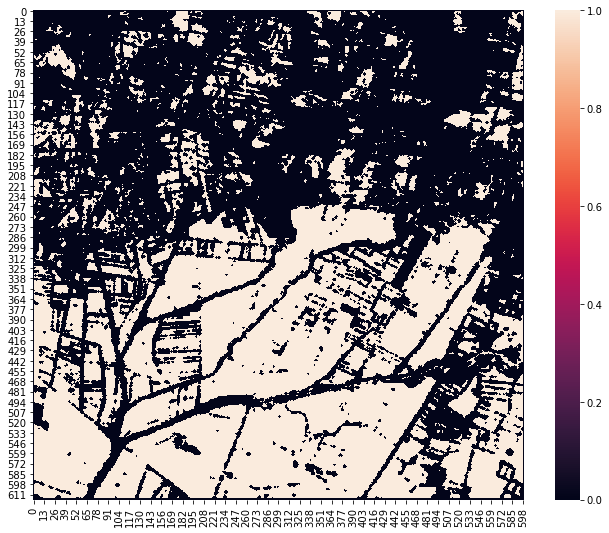

In [6]:
fs, changemap, stable, notree = load_ttc_tiles(x, y)
plt.figure(figsize=(11,9))
sns.heatmap((notree))

Starting download of s3://tof-output/2017/change/376/1206/376X1206Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2018/change/376/1206/376X1206Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2019/change/376/1206/376X1206Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2020/change/376/1206/376X1206Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2021/change/376/1206/376X1206Y_ard.zip to output.zip from tof-output
Starting download of s3://tof-output/2022/change/376/1206/376X1206Y_ard.zip to output.zip from tof-output
(1, 618, 600) (1, 618, 600)


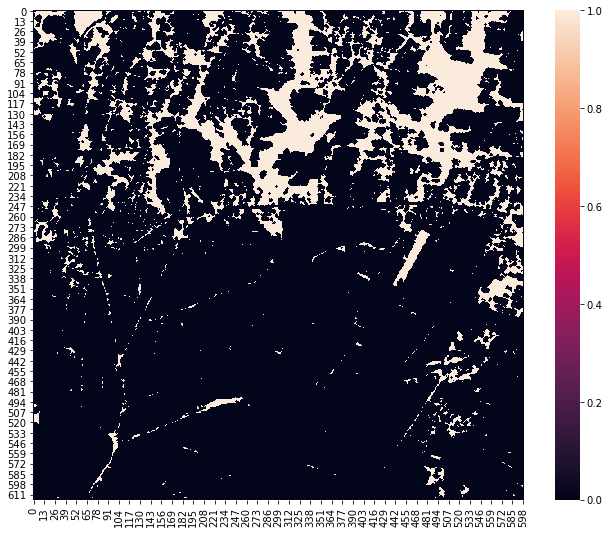

In [7]:
year = 2020

download_and_unzip_data(x, y)
bbx = tile_bbx(x, y)
a17, a18, a19, a20, a21, a22, d17, d18, d19, d20, d21, d22 = load_all_ard(x, y)
local_path = '../../project-monitoring/tiles/'
ard_path = f'{local_path}/{str(year)}/{str(x)}/{str(y)}/'
dem = f'{ard_path}/dem_{str(x)}X{str(y)}Y.hkl'
dem = hkl.load(dem)
dem = median_filter(dem, size = 9)
dem = resize(dem, (a17.shape[1:]), 0)

fs, changemap, stable, notree = load_ttc_tiles(x, y)
plt.figure(figsize=(11,9))
sns.heatmap((stable))

This is the per-image NDMI across the entire image (in blue)
and the per-image NDMI for stable trees (in green)

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

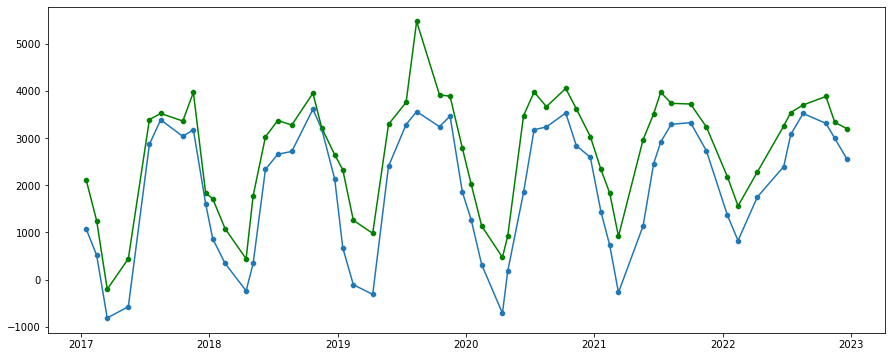

In [8]:
ard = np.concatenate([a17, a18, a19,a20, a21, a22])#, a22])#, a21, a22])#, a21, a22])#,
dates = np.concatenate([d17, d18, d19, d20, d21, d22])#$, d22])#, d21, d22])#, d21, d22])

plt.figure(figsize=(15,6))
sns.scatterplot((dates / 365) + 2017, np.median(ard[:, notree], axis = (1)), )
sns.lineplot((dates / 365) + 2017, np.median(ard[:, notree], axis = (1)), )
sns.scatterplot((dates / 365) + 2017, np.median(ard[:, stable], axis = (1)), color = 'green')
sns.lineplot((dates / 365) + 2017, np.median(ard[:, stable], axis = (1)), color = 'green')

In [9]:
if changemap is not None:
    gain = changemap == 250
    mean_gain = np.mean(ard[:, gain], axis = (1))
    mean_loss = np.mean(ard[:, changemap == 150], axis = (1))
    mean_nochange_tree = np.mean(ard[:, np.logical_and(changemap <= 100, changemap > 20)], axis = (1))
    mean_notree = np.mean(ard[:, changemap <= 20], axis = (1))

    plt.figure(figsize=(15,7))
    g = sns.scatterplot((dates / 365) + 2017, mean_gain, color = 'purple')
    g = sns.lineplot((dates / 365) + 2017, mean_gain, color = 'purple', label = 'Gain')
    g = sns.scatterplot((dates / 365) + 2017, mean_loss, color = 'red')
    g = sns.lineplot((dates / 365) + 2017, mean_loss, color = 'red', label = 'Loss')
    g = sns.scatterplot((dates / 365) + 2017, mean_nochange_tree, color = 'green')
    g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable')
    g.set(ylabel = 'Normalized difference moisture index')

In [10]:
from scipy.stats import gaussian_kde
from scipy.special import ndtr

d = ard[:, stable]
d = d.swapaxes(0, 1)
# Sample up to 10% of the image (600 * 600) of the stable pixels
dsamp = np.random.randint(0, d.shape[0], np.minimum(36000, d.shape[0]))
d = d[dsamp]
print(d.shape)

# And calculate the per-image 5th percentile CDF NDMI
def make_and_analyze_kde_for_one_img(ard, step, ref):
    kde = gaussian_kde(ref[:, step])
    reg_grid = np.arange(-10000, 10000, 10)
    cdf = tuple(ndtr(np.ravel(item - kde.dataset) / kde.factor).mean()
            for item in reg_grid)
    cdf_5_percentile = np.array(reg_grid)[np.argmin(abs(np.array(cdf) - 0.05))]
    cdf_10_percentile = np.array(reg_grid)[np.argmin(abs(np.array(cdf) - 0.10))]
    cdf_25_percentile = np.array(reg_grid)[np.argmin(abs(np.array(cdf) - 0.25))]
    cdf_50_percentile = np.array(reg_grid)[np.argmin(abs(np.array(cdf) - 0.50))]
    f = ard[step] >= cdf_5_percentile
    m = ard[step] >= cdf_10_percentile
    b = ard[step] >= cdf_25_percentile
    h = ard[step] >= cdf_50_percentile
    
    percentiles = np.zeros_like(ard[step], dtype = np.float32)
    for i in range(0, 100, 5):
        fraction = i / 100
        cdf_percentile = np.array(reg_grid)[np.argmin(abs(np.array(cdf) - fraction))]
        is_greater = ard[step] >= cdf_percentile
        percentiles[is_greater] = fraction
        
    return f, m, b, h, percentiles

percentiles = np.zeros_like(ard, dtype = np.float32)
kde = np.zeros_like(ard)
kde10 = np.zeros_like(ard)
kde50 = np.zeros_like(ard)
kde_expected = np.zeros_like(ard)
for i in range(ard.shape[0]):
    kde[i], kde10[i], kde_expected[i], kde50[i], percentiles[i] = make_and_analyze_kde_for_one_img(ard, i, d)    

(36000, 56)


2018 0
2019 1
2020 2
2021 3
2022 4


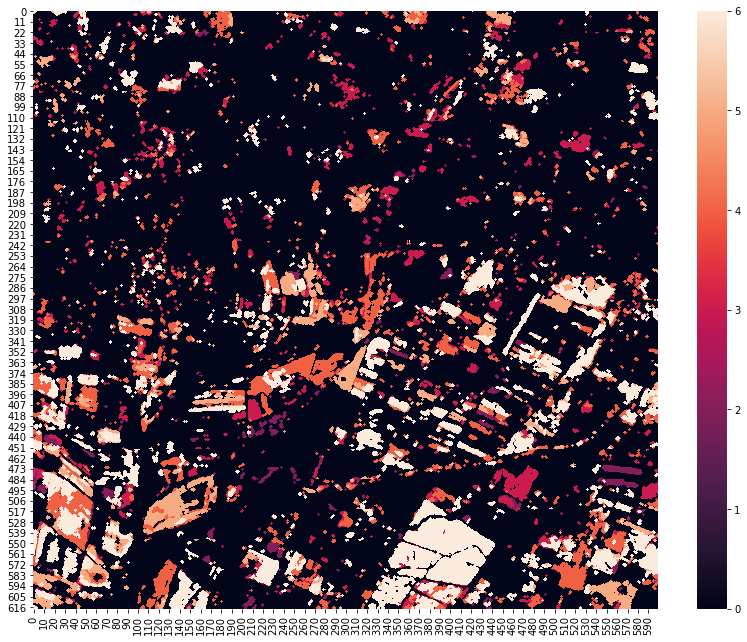

In [11]:
from numpy.lib.stride_tricks import sliding_window_view
from scipy import ndimage

def remove_noise(arr, thresh = 15):
    Zlabeled,Nlabels = ndimage.measurements.label(arr)
    label_size = [(Zlabeled == label).sum() for label in range(Nlabels + 1)]
    for label,size in enumerate(label_size):
        if size < thresh:
            arr[Zlabeled == label] = 0
    return arr

def identify_anomaly_events(inp, n, shape):
    inp_ = inp == n    
    sums = np.sum(sliding_window_view(inp_, window_shape = (shape, 1, 1)), axis = 3).squeeze()
    sums = np.concatenate([np.zeros_like(sums[0])[np.newaxis],
                           sums,
                           np.zeros_like(sums[0])[np.newaxis]], axis = 0)
    return sums


def identify_gain_in_year(kde, year):
    if year > 2018:
        negative_anomaly_after = identify_anomaly_events(kde10, 0, 3) == 3
        negative_anomaly_prior = identify_anomaly_events(kde10, 0, 3) == 3
        positive_anomaly = identify_anomaly_events(kde10, 1, 3) == 3
    if year == 2018:
        # For first year of gain, remove lower confidence events by:
           # - Requiring negative anomaly to be < 5%
        negative_anomaly_prior = identify_anomaly_events(kde, 0, 3) == 3
        negative_anomaly_after = identify_anomaly_events(kde10, 0, 3) == 3
        positive_anomaly = identify_anomaly_events(kde10, 1, 4) == 4
        
    #positive_anomaly = identify_anomaly_events(kde10, 1, 3) == 3
    
    img_prior3_start = np.sum(dates <= ((year - 2017 - 3) * 365 ))
    img_prior2_start = np.sum(dates <= ((year - 2017 - 2) * 365 ))
    img_prior_start = np.sum(dates <= ((year - 2017 - 1) * 365 ))
    img_current_start = np.sum(dates <= ((year - 2017) * 365 ))
    img_next_start = np.sum(dates <= ((year - 2017 + 1) * 365 ))
    img_next_end = np.sum(dates <= ((year - 2017 + 2) * 365 ))
    img_next2_end = np.sum(dates <= ((year - 2017 + 3) * 365 ))

    if year == 2017:
        img_current_start = img_next_start

    # Loss event in Y-2, Y-1 or in Y0
    negative_prior = np.sum(negative_anomaly_prior[img_prior3_start:img_next_start], axis = 0) > 0
    
    # Tree event in Y + 1
    positive_after = np.sum(positive_anomaly[img_current_start:img_next2_end], axis = 0) > 0
    # No loss event in Y + 1
    negative_after = np.sum(negative_anomaly_after[img_next_start:img_next_end], axis = 0) > 0
    
    candidate_gain = (negative_prior) *(1 - negative_after) * (positive_after)
    struct = ndimage.generate_binary_structure(2, 1)
    candidate_gain = binary_dilation(1 - (binary_dilation(1 - candidate_gain)))
    candidate_gain = remove_noise(candidate_gain, 10)
    return candidate_gain


def identify_loss_in_year(kde, year):
    # A loss is defined as: 
    # - A medium confidence tree sometime in the last 2 years (90% confident)
    # - No high confidence tree in the next year (50% confident)
    # - Negative anomaly in Y0 or Y-1, or Y+1 
    # Note that the (the negative anomaly may show up after TTC identifies the loss, as
    # the anomaly needs consistency between many images)
    
    positive_anomaly = identify_anomaly_events(kde_expected, 1, 3) == 3
    positive_anomaly17 = identify_anomaly_events(kde10, 1, 3) == 3
    negative_anomaly = identify_anomaly_events(kde, 0, 3) == 3
    
    img_2prior_start = np.sum(dates <= ((year - 2017 - 2) * 365 ))
    img_prior_start = np.sum(dates <= ((year - 2017 - 1) * 365 ))
    img_current_start = np.sum(dates <= ((year - 2017) * 365 ))
    img_next_start = np.sum(dates <= ((year - 2017 + 1) * 365 ))
    img_next_end = np.sum(dates <= ((year - 2017 + 2) * 365 ))
    img_next2_end = np.sum(dates <= ((year - 2017 + 3) * 365 ))

    if year == 2017:
        positive_anomaly = positive_anomaly17
    
    # Medium confidence tree sometime in last 2 years (10%)
    positive_prior = np.sum(positive_anomaly[img_2prior_start:img_next_start], axis = 0) > 0

    # Negative anomaly In this year, year before, or year after
    negative_after = np.sum(negative_anomaly[img_prior_start:img_next2_end], axis = 0) > 0
    candidate_loss =  positive_prior * negative_after #* positive_prior #(1 - positive_after)
    struct = ndimage.generate_binary_structure(2, 1)
    
    candidate_loss = binary_dilation(1 - (binary_dilation(1 - candidate_loss)))
    return candidate_loss

def remove_nonoverlapping_events(candidate, anomaly, thresh = 2):
    #direct_overlap = candidate * anomaly
    candidate_labels, n = ndimage.measurements.label(candidate)
    for i in range(n):
        candidate_i = candidate_labels == i
        if np.sum(anomaly[candidate_i]) < (np.sum(candidate_i) / thresh):
            candidate[candidate_i] = 0.
   # candidate = np.maximum(candidate, direct_overlap)
    return candidate

def prop_overlapping_events(before, current, thresh):
    candidate_labels, n = ndimage.measurements.label(before)
    for i in range(1, n):
        before_i = before == i
        if np.sum(current[before_i]) > (np.sum(before_i > 0) / thresh):
            current[before_i] = 1.
    return current

def identify_outliers(inp):
    inp_ = inp == 0
    m = np.diff(np.where(np.concatenate(([inp_[0]],
                                         inp_[:-1] != inp_[1:],
                                         [True])))[0])[::2]
    return np.max(m) if m.shape[0] > 0 else 0

gain = np.zeros((5, ard.shape[1], ard.shape[2]))
loss = np.zeros((5, ard.shape[1], ard.shape[2]))

for i in range(5):
    print(2017 + i + 1, i)
    gain[i] = identify_gain_in_year(kde, 2017 + i + 1) * (i + 2)
    loss[i] = identify_loss_in_year(kde, 2017 + i + 1) * (i + 2)
    
plt.figure(figsize=(14,11))
sns.heatmap(np.max(loss, axis = 0))

## English version

Consider the year 2019.

If all images in 2017 and 2018 have at least 1 anomaly, e.g. 4 or more consecutive images with RDF < 0.05, then we say that at some point prior to 2019  there was no tree on that pixel.

For year 2019 and 2020, if there are no anomalies, e.g. 3 or less consecutive images with RDF < 0.05, then we say that in 2019 and 2020 there is a tree on that pixel.

In [12]:
fs = fs.astype(np.float32)
ff = temporal_filter(fs)

loss22 = identify_loss_in_year(kde, 2022)
candidateloss2022 = ((ff[4] - ff[5]) >= 50)* (ff[4] > 50) * (ff[3] > 50) * (ff[5] < 25)
loss22 = remove_nonoverlapping_events(candidateloss2022, loss22, 2)
loss22 = remove_noise(loss22, thresh = 15)

gain18 = ((ff[1] - ff[0]).squeeze() >= 50) * (ff[0] < 30) * (ff[2] > 50)
gain18 = remove_nonoverlapping_events(gain18, gain[0], 2)
gain18 = remove_noise(gain18, thresh = 15).squeeze() * 1
gain18 = np.clip(gain18, 0, 1)

loss18 = identify_loss_in_year(kde, 2018)
candidateloss2018 = ((ff[0] - ff[1]).squeeze() >= 60) * (ff[0] > 60) * (ff[1] < 30)
loss18 = remove_nonoverlapping_events(candidateloss2018, loss18, 2)
loss18 = loss18.squeeze() * 1

In [13]:
gain2 = np.copy(gain)
gain2[0] = 0.

candidate2019 = (((ff[2] - np.min(ff[0:2], axis = 0)) > 50) * 
                       (ff[2] > 30)  * (ff[3] > 30)) # * (ff[1] < 30)
gain2[1] = remove_nonoverlapping_events(candidate2019, np.max(gain2[1:2], axis = 0), 3) * 2

candidate2020 = (((ff[3] - np.min(ff[1:3], axis = 0)) > 50) * 
                       (ff[3] > 30)* (ff[4] > 30)) #  * (ff[2] < 25) 

gain2[2] = remove_nonoverlapping_events(candidate2020, np.max(gain2[2:3], axis = 0), 3) * 3

candidate2021 = (((ff[4] - np.min(ff[2:4], axis = 0)) > 50) * 
                       (ff[4] > 30) * (ff[5] > 30)) # * (ff[3] < 25) 

gain2[3] = remove_nonoverlapping_events(candidate2021, np.max(gain2[3:4], axis = 0), 3) * 4

candidate2022 = ((ff[5] - np.min(ff[3:5], axis = 0) >= 50) * (ff[5] > 50))
candidate2022 = candidate2022 * np.logical_or(ff[4] < 30, ff[3] < 30)
gain2[4] = remove_nonoverlapping_events(candidate2022, np.max(gain2[4:5], axis = 0), 2) * 5

gain2[gain2 == 0] = 255
gain2 = np.min(gain2, axis = 0)
gain2[gain2 == 255] = 0.
gain2[gain18 > 0] = gain18[gain18 > 0] * 1


loss2 = np.copy(loss)
loss2[0] = 0.

# Remove_nonoverlaping needs a size and fraction thresh, not just fraction
#! TODO!!
#! TODO!!
#! TODO!!
#! TODO!!
# We assume that loss does not happen until the tree has been detected for 2 years. 
# Gain can happen the year after loss, though.
# So 1 1 0 1 is permitted as loss. 0 1 0 0 is not.
candidate2019 = ((ff[1] - ff[2]) > 50) * (ff[2] < 30) * (ff[1] > 40) * (ff[0] > 40)
loss2[1] = remove_nonoverlapping_events(candidate2019, loss2[1], 4) * 2
candidate2020 = ((ff[2] - ff[3]) > 50) * (ff[3] < 30) * (ff[2] > 40) * (ff[1] > 40)
loss2[2] = remove_nonoverlapping_events(candidate2020, loss2[2], 4) * 3
candidate2021 = ((ff[3] - ff[4]) > 50) * (ff[4] < 30) * (ff[3] > 40) * (ff[2] > 40)
loss2[3] = remove_nonoverlapping_events(candidate2021, loss2[3], 4) * 4
candidateloss2022 = ((ff[4] - ff[5]) >= 50)* (ff[4] > 50) * (ff[3] > 50) * (ff[5] < 30)
loss2[4] = remove_nonoverlapping_events(candidateloss2022, loss2[4], 4) * 5


loss2[loss2 == 0] = 255
loss2 = np.min(loss2, axis = 0)
loss2[loss2 == 255] = 0.
#loss2 = loss2 * (changemap == 150)
loss2[np.logical_and(loss2 == 0, loss18 > 0)] = loss18[np.logical_and(loss2 == 0, loss18 > 0)] * 1

# For loss year 2018-2020, if 2021-2022 have trees, but there is no regain, then remove the loss event
loss_noregain = ((np.median(fs[-3:], axis = 0) > 30) *
                   (gain2 <= 3) * (loss2 <= 4)) * (loss2 > 0)

# For gain year 2018-2020, if 2021-2022 have no trees, but there is no reloss, then remove the gain event
gain_no_reloss = ((np.median(fs[-3:], axis = 0) <= 30) *
                   (gain2 <= 4) * (loss2 <= 3)) * (gain2 > 0)

#loss2 = loss2 * (1 - loss_noregain)
#gain2 = gain2 * (1 - gain_no_reloss)

losses = np.copy(loss2) > 0
losses = remove_noise(losses, 10)
losses[losses > 0] = 1.
loss2 = loss2 * losses 

gains = np.copy(gain2) > 0
gains = remove_noise(gains, 10)
gains[gains > 0] = 1.
gain2 = gain2 * gains

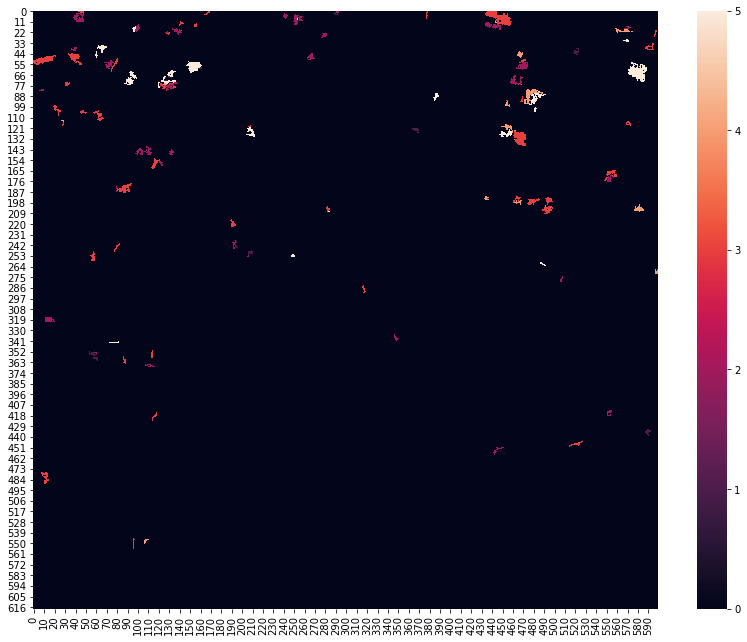

In [14]:
plt.figure(figsize=(14,11))
rotational = np.logical_and(gain2 > 0, loss2 > 0)
med = np.median(fs, axis = 0)
med[gain2> 0] = (gain2[gain2 > 0] + 100)
med[loss2 > 0] = (loss2[loss2 > 0] + 200)
med[np.logical_and(rotational, gain2 > loss2)] = 150.
med[np.logical_and(rotational, loss2 > gain2)] = 160.

sns.heatmap(loss2)

In [15]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

movingavg = np.copy(percentiles).reshape((percentiles.shape[0], percentiles.shape[1] * percentiles.shape[2]))
movingavg = np.apply_along_axis(moving_average, 0, movingavg, 9)
movingavg = np.reshape(movingavg, (percentiles.shape[0]-8,percentiles.shape[1], percentiles.shape[2]))

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


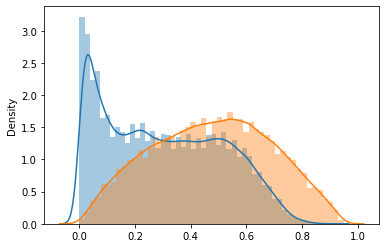

In [16]:
mins = np.percentile(movingavg[:, stable], 50, axis = 0)
maxs = np.percentile(movingavg[:, notree], 50, axis = 0)
sns.distplot(maxs)
sns.distplot(mins)


In [17]:
from skimage.filters.rank import mean
from scipy.ndimage import median_filter

# Because our minimum mapping unit is 10 px
for i in range(movingavg.shape[0]):
    movingavg[i] = median_filter(movingavg[i], 5)
    

In [18]:

refrange = (np.percentile(movingavg[8:-8], 97.5, axis = 0) - np.percentile(movingavg[8:-8], 2.5, axis = 0)) * stable
np.mean(refrange) + (2.5*np.std(refrange))
#np.percentile(refrange, 95)

0.25609106129973624

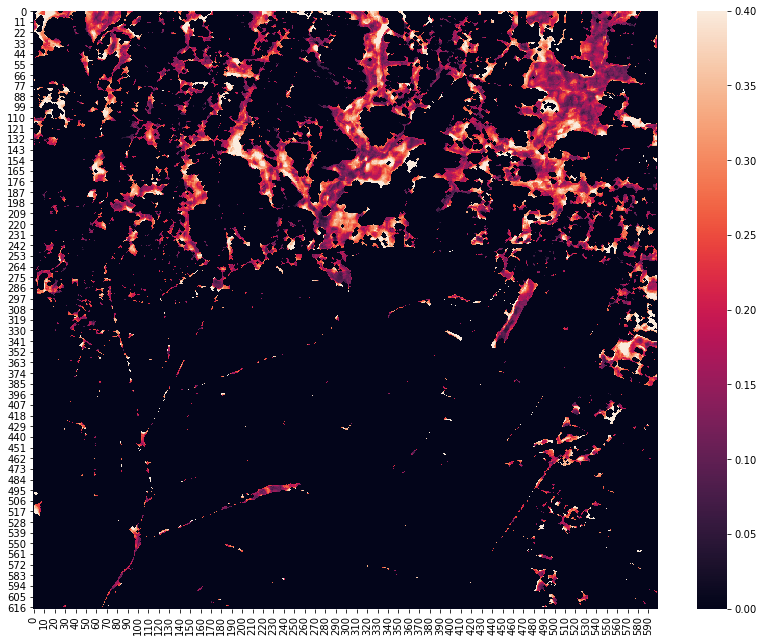

In [19]:
#sns.lineplot(dates[4:-4], movingavg[:, np.argwhere(refrange > 0.36)[35][0], 
#                                    np.argwhere(refrange > 0.36)[35][1]])
plt.figure(figsize=(14,11))
sns.heatmap(refrange, vmax = 0.4)

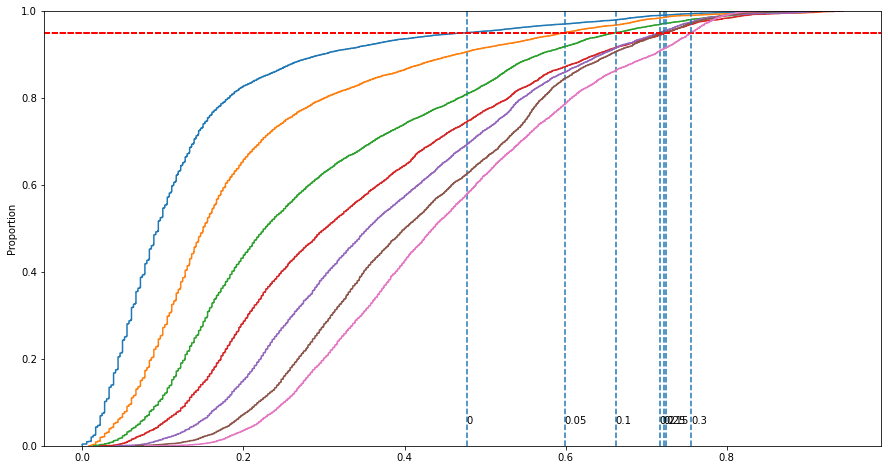

In [20]:
plt.figure(figsize=(15,8))
for i in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    baseline = i

    counterfactual = np.mean(movingavg[:6], axis = 0)
    counterfactual = np.logical_and(notree, np.logical_and(counterfactual >= baseline,
                                                           counterfactual < baseline + 0.05))
    counterfactual = np.percentile(movingavg[6:-10, counterfactual], 95, axis = 0)
    #counterfactual.shape
    #sns.heatmap(counterfactual)
    
    g = sns.ecdfplot(counterfactual.flatten())#, kind = 'kde')
    g.axhline(0.95, ls='--', color = 'red')
    endline =  np.percentile(counterfactual, 95)
    g.axvline(endline, ls='--')
    g.text(endline, 0.05, i)
    #endline = np.around(endline, 3)
    #g.set_title(f"Baseline: {baseline}, endline: {endline}")






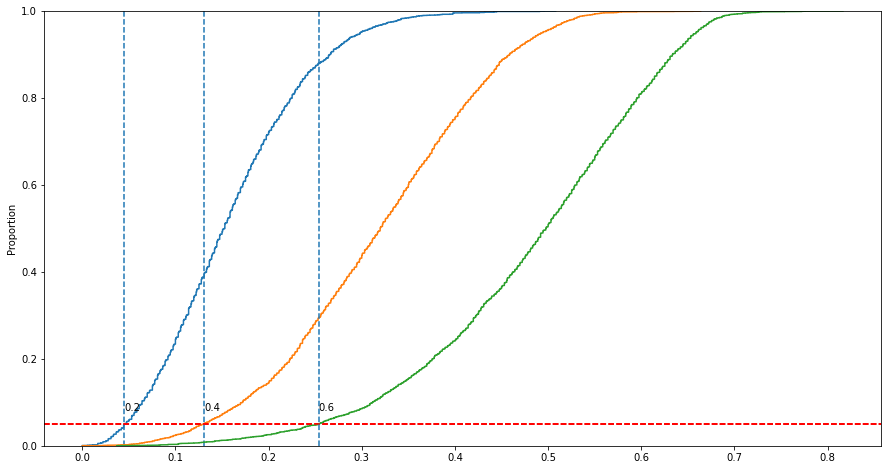

In [21]:

plt.figure(figsize=(15,8))
for i in [0.2, 0.4,0.6]:
    baseline = i

    counterfactual = np.mean(movingavg[:6], axis = 0)
    counterfactual = np.logical_and(stable, np.logical_and(counterfactual >= baseline,
                                                           counterfactual < baseline + 0.05))
    counterfactual = np.percentile(movingavg[6:-10, counterfactual], 5, axis = 0)
    #counterfactual.shape
    #sns.heatmap(counterfactual)
    
    g = sns.ecdfplot(counterfactual.flatten())#, kind = 'kde')
    g.axhline(0.05, ls='--', color = 'red')
    endline =  np.percentile(counterfactual, 5)
    g.axvline(endline, ls='--')
    g.text(endline, 0.08, i)
    #endline = np.around(endline, 3)
    #g.set_title(f"Baseline: {baseline}, endline: {endline}")



In [22]:
import math
def round_up(x, a):
    return math.ceil(x / a) * a

def round_down(x, a):
    return math.floor(x / a) * a

def calc_reference_change(movingavg, slopemin, slopemax):
    counterfactuals = []
    prior = 0.2
    lowest_change = 0.15
    previous_change = 0.15
    for i in range(0, 60, 5):
        baseline = i / 100
        counterfactual = np.mean(movingavg[:6], axis = 0)
        counterfactual = np.logical_and(notree, np.logical_and(counterfactual >= baseline, counterfactual < baseline + 0.05))
        if np.mean(dem >= slopemin) > 0.05:
            counterfactual = np.logical_and(counterfactual, (dem >= slopemin))#, dem < slopemax))
            counterfactual = np.logical_and(counterfactual, (dem <= slopemax))#, dem < slopemax))
        npx = np.sum(counterfactual)
        if np.sum(counterfactual) > 500:  

            if ((i / 100) < 0.10):# or npx > 2000:
                #print(movingavg.shape)
                #upper_percentile = np.percentile(movingavg[6:-6, counterfactual], 90, axis = 0)
                #counterfactual = np.percentile(upper_percentile, 90)
                counterfactual = np.percentile(movingavg[6:-10, counterfactual], 97.5) # 97.5
                #print(i, counterfactual, prior)
            elif slopemin >= 20:
                 counterfactual = np.percentile(movingavg[6:-6, counterfactual], 97.5) # 97.5
            else:
                #upper_percentile = np.percentile(movingavg[6:-6, counterfactual], 80, axis = 0)
                #counterfactual = np.percentile(upper_percentile, 90)
                counterfactual = np.percentile(movingavg[6:-10, counterfactual], 95)

            prior = counterfactual
            change = (counterfactual - baseline)
            #change = np.maximum(change, baseline - 0.20)
        else:
            
            counterfactual = previous_change + 0.065
            #counterfactual = np.maximum(counterfactual, baseline - 0.05)
            change = (counterfactual - baseline)
            #change = np.maximum(change, baseline - 0.10)
            #print(baseline - 0.05)
            #print(i / 100, counterfactual)
        #if i != 0:
        #    counterfactual = np.maximum(counterfactual, prior + 0.05)
        #change = (counterfactual - baseline)
        change = np.clip(change, 0.15, 0.4)
        lowest_change += 0.0025
        lowest_change = np.maximum(lowest_change, change)
        change = np.maximum(lowest_change, change)
        counterfactual = baseline + change
        
        reference = counterfactual #- 0.05
        #print(i / 100, (counterfactual - (i / 100)))
        print(f"{slopemin}: Target change from {baseline} is {np.around(change, 2)} to {np.around(reference, 2)}, {npx}")
        print(i / 100, previous_change - baseline)
        counterfactuals.append(counterfactual)
        #if (counterfactual - baseline) > previous_change:
        previous_change = counterfactual
        #else:
        #    previous_change += 0.10
    return counterfactuals

def calc_tree_change(movingavg, pct):
    counterfactuals = []
    for i in range(20, 80, 5):
        baseline = i / 100
        counterfactual = np.percentile(movingavg, 80, axis = 0)
        #counterfactual = np.logical_and(stable,
        #                               np.logical_andd())
        counterfactual = np.logical_and(stable, np.logical_and(counterfactual >= baseline, counterfactual < baseline + 0.05))
        #print(counterfactual.shape)
       # print(movingavg.shape[0] -10)
        counterfactual = np.percentile(np.percentile(
            movingavg[:, counterfactual], 20, axis = 0), pct)
        #counterfactual = np.percentile(movingavg[10:-10, counterfactual], pct)
        #counterfactual = baseline - 0.506
        #counterfactual = np.clip(counterfactual, 0.025, 1.)
        print(i, i / 100, counterfactual)
        counterfactuals.append(counterfactual)
    return counterfactuals

def calc_threshold_for_notree(maxval, cfs_trees):
    maxval = round_down(maxval, 0.05)
    maxval = np.clip(maxval, 0.2, 0.75)
    thresh = cfs_trees[int(maxval // 0.05) - 3]
    return thresh

def calc_tree_change(movingavg, pct):
    counterfactuals = []
    for i in range(20, 80, 5):
        baseline = i / 100
        high = np.percentile(movingavg[8:-8], 90, axis = 0)
        highlocs = np.logical_and(stable, np.logical_and(high >= baseline, high < baseline + 0.05))
        high = high[highlocs]
        low = np.percentile(
            movingavg[8:-8, highlocs], 10, axis = 0)
        refrange = high - low
        change = np.mean(refrange) + (2*np.std(refrange))
        change2 = np.percentile(refrange, 90)
        change = np.minimum(change, change2)
        print(i / 100, change, baseline - change, np.sum(highlocs > 0))
        counterfactuals.append(baseline - change)
    return counterfactuals

#calc_tree_change(movingavg, 5)

cfs_flat = calc_reference_change(movingavg, 0, 50)
cfs_hill = calc_reference_change(movingavg, 10, 50)
cfs_steep = calc_reference_change(movingavg, 20, 50)
cfs_trees = calc_tree_change(movingavg, 5)
cfs_trees10 = calc_tree_change(movingavg, 10)

0: Target change from 0.0 is 0.4 to 0.4, 20528
0.0 0.15
0: Target change from 0.05 is 0.4 to 0.45, 15637
0.05 0.35000000000000003
0: Target change from 0.1 is 0.4 to 0.5, 11995
0.1 0.35250000000000004
0: Target change from 0.15 is 0.41 to 0.56, 9429
0.15 0.355
0: Target change from 0.2 is 0.41 to 0.61, 8153
0.2 0.3575
0: Target change from 0.25 is 0.41 to 0.66, 8625
0.25 0.3600000000000001
0: Target change from 0.3 is 0.42 to 0.72, 9672
0.3 0.3625000000000001
0: Target change from 0.35 is 0.42 to 0.77, 10010
0.35 0.3650000000000001
0: Target change from 0.4 is 0.42 to 0.82, 10142
0.4 0.36750000000000005
0: Target change from 0.45 is 0.42 to 0.87, 9919
0.45 0.37000000000000005
0: Target change from 0.5 is 0.43 to 0.92, 9348
0.5 0.37250000000000005
0: Target change from 0.55 is 0.43 to 0.98, 9076
0.55 0.375
10: Target change from 0.0 is 0.17 to 0.17, 511
0.0 0.15
10: Target change from 0.05 is 0.17 to 0.22, 568
0.05 0.1222222218910853
10: Target change from 0.1 is 0.19 to 0.29, 521
0.1 0

In [23]:
from scipy.ndimage.filters import minimum_filter1d
def min_filter1d(a, W):
    hW = (W-1)//2 # Half window size
    return minimum_filter1d(a,size=W)#[hW:-hW]


def check_for_gain_subtle(ma):
    gain_events = []
    threshes = [0.025, 0.05]
    for thresh in threshes:
        ma_below5 = np.argwhere(ma < thresh).flatten()
        for i in ma_below5:
            if i < (ma.shape[0] - 5) and (i >= 3):
            # check for two in a row at 0.025, and 3 in a row at 0.05
            # This indicates there was no tree before
                numb = 3 if thresh == 0.05 else 2
                if np.sum(ma[i:i + numb] <= thresh) == numb:
                    # Check for no loss in future
                    # Check for tree in future
                    #print(i, "CANDIDATE")
                    if np.sum(ma[i+2:i+22] < thresh) == 0:
                        previous_tree = (np.sum(ma[:i] > 0.10) >= 2)
                        future_tree = (np.sum(ma[i:] > 0.10) >= 10)
                        #print(previous_tree, future_tree)
                        #print(previous_tree)# >= 3
                        if previous_tree == False and future_tree == True:
                            gain_events.append(i)
    return gain_events

In [24]:
def check_for_gain_large(ma, deforested, reference, counterfactual, verbose = False):
    
    minimum5win = min_filter1d(ma, 3)
    gain_events = []

    if deforested:
        deforested_date = np.maximum(np.argmin(ma), 3)
        upper_limit = np.max(ma[deforested_date:deforested_date + 6])
        upper_limit = np.maximum(upper_limit, 0.3)

    # If not deforested, we assume that the gain is non tree to tree
    # Rather than tree - no tree - tree, as the latter would
    # Indicate deforestation. 
    if not deforested:
        # We start by lookign at the first 3 (so 7) images
        # And, assuming that the pixel is not a tree
        # Calculate the 95th% confidence range for remaining non-tree
        baseline = round_down(np.mean(ma[:3]), 0.05)
        baseline = np.clip(baseline, 0.0, 0.40)
        target = counterfactual[int(baseline // 0.05)]
        #print(f"Target change from {baseline} is {target}")
        change = (target - baseline)
        reference = target

        # However, if it is a missed deforestation event, then we can "re-set"
        # the baseline
    else:
        # If it is deforested, then it just has to re-reach the 90th percentile
        # Of non-tree values.
        change = reference - 0.05
        change = np.clip(change, 0.15, 0.35)
    #print(ma)
    for i in range(ma.shape[0]):
        if i < (ma.shape[0] - 6) and (i >= 2):
            # Look for 6 dates in a row below reference = stable no-tree
            # And 5 dates in a row above reference = stable tree
            
            if deforested or (i < 6):
                n_lookback = 2 if (i - 2) > 0 else i
            else:
                n_lookback = i
                
            # If not deforested, look for the whole history to this point.
            # If deforested, just look at the last 3 images. 
            current_baseline = np.median(ma[i-n_lookback:i])

            baseline = current_baseline

            if (baseline < 0.6) or deforested:
                if baseline > 0.1:
                    baseline = round_up(baseline, 0.05)
                else:
                    baseline = round_down(baseline, 0.05)
                baseline = np.clip(baseline, 0.0, 0.60)
                reference = counterfactual[int(baseline // 0.05)]
                noise_factor = 0
                if not deforested:
                    bs = np.median(ma[i-n_lookback:i])
                    positive_deviations = np.argwhere(ma[:i] > (bs))
                    positive_deviations = positive_deviations[positive_deviations > (i - 10)]
                    if len(positive_deviations) > 0:
                        #print()
                        noise_factor = np.mean(ma[positive_deviations] - bs)
                        #print(positive_deviations, noise_factor)
                        #noise_factor = np.std(ma[:i]) * 1.5
                        reference += 0.5*noise_factor

                change = (reference -  baseline)
               #print(baseline, reference, change)
                # Do at least 3 image dates in the future reach the tree reference threshold? 
                endline = minimum5win[i+1:ma.shape[0]]
                lastdate_gain = False
                if np.argmax(endline - baseline) >= (endline.shape[0] - 2):
                    if baseline < 0.25:
                        endline = np.array(ma[-1])
                        reference -= ((noise_factor) / 2)
                        change = (reference - baseline)
                        lastdate_gain = True
                if verbose:
                    print(f"{i}, Base/end: {np.around(baseline, 3), np.max(endline)},"
                          f" change/ref: {np.around(change, 3), reference}")
                # Identify whether change threshold is met, and reference is reached
                if (np.max(endline) - baseline) > change and (np.max(endline) > reference):
                    #print("WTF")
                    if lastdate_gain:
                        max_before = np.max(ma[:i])
                        max_after = np.max(ma[-6:])
                        no_cyclical_ndmi = max_after > (max_before * 1.25)
                        no_cyclical_ndmi = np.logical_or(no_cyclical_ndmi, deforested)
                        if no_cyclical_ndmi:
                            gain_events.append(i)
                    else:
                        #try:
                        gain_date = np.argwhere(np.logical_and(np.array(endline >= reference),
                                                           np.array((endline - baseline) > change)
                                                          )).flatten()[0] + i

                        imgs_after_gain = ma[gain_date:gain_date + 8]

                        if gain_date < (ma.shape[0] - 6):
                            gain_date_after = np.argwhere(imgs_after_gain > np.percentile(
                                            imgs_after_gain, 50)).flatten()[0] + gain_date
                        else:
                            gain_date_after = gain_date
                        gain_value = ma[gain_date]
                        gain_value_max = np.max(ma[gain_date:gain_date + 10])
                        max_value = np.max(ma[gain_date:])
                        reference_min = calc_threshold_for_notree(gain_value, cfs_trees) + 0.10
                        reference_min_prior = calc_threshold_for_notree(max_value, cfs_trees10)
                        #reference_min_prior_gv = calc_threshold_for_notree(gain_value, cfs_trees10)
                        #reference_min_prior = np.minimum(reference_min_prior, reference_min_prior_gv)
                        #print(max_value, reference_min_prior, reference_min_prior_gv)
                        # TEST BLOCK
                        if gain_date >= 10:
                            notree_before = np.sum(ma[:gain_date] < (reference_min_prior)) > 0
                        else:
                            notree_before = np.sum(ma[:gain_date] < (reference_min_prior)) > 0
                        #notree_before = True
                        max_before = np.max(ma[:i])
                        max_after = np.max(ma[gain_date:])

                        no_cyclical_ndmi = max_after > (max_before * 1.25)
                        #print(np.argmin(ma))
                        no_cyclical_ndmi = np.logical_or(no_cyclical_ndmi, np.argmin(ma) == 0)
                        #print(no_cycle_ndmi)
                        #print(np.sum(ma[:gain_date] < (reference_min_prior)),
                        #             reference_min_prior, gain_date, notree_before)
                        notree_before = np.logical_and(notree_before, no_cyclical_ndmi)
                        notree_before = np.logical_or(notree_before, deforested)

                        min_next_6 = (np.min(ma[gain_date_after:gain_date + 8]))
                        no_loss_after_gain = min_next_6 > (reference_min)
                        reference_min = calc_threshold_for_notree(np.max(ma[gain_date:]), cfs_trees)
                        no_loss_after_gain_long = (np.sum(ma[gain_date_after:] < (reference_min)) == 0)
                        no_loss_after_gain = np.logical_and(no_loss_after_gain, no_loss_after_gain_long)
                        no_loss_after_gain = np.logical_or(deforested, no_loss_after_gain)
                        #no_loss_after_gain = True
                        if (gain_date - 5) > i:
                            no_decrease_until_gain = np.min(np.array(ma[i+5:gain_date])) >= ma[i]
                        else:
                            no_decrease_until_gain = True
                        if verbose:
                            print(i, gain_value, ma[i], no_loss_after_gain, no_decrease_until_gain, notree_before)
                        if no_loss_after_gain and no_decrease_until_gain:
                            if notree_before:
                                #print(i)
                                gain_events.append(i)
                        #except:
                        #    print("exception")
                        #    continue
   # print(len(gain_events))
   # print(gain_events)
    if len(gain_events) > 0:
        if (len(gain_events) > 2) or ((np.max(gain_events) > (ma.shape[0] - 3))):
            return gain_events
        elif (len(gain_events) >= 2) and deforested:
            return gain_events
        else:
            return []
    else:
        return []

Reference: 0.4
No addtl gain 359415
0 No Large Gain detected: []: False, 359748
11 9
11 Large Gain detected: 9 events: False, 3.0, 1 Slope: 6.540327548980713, 42 px
11
13 6
13 Large Gain detected: 6 events: False, 5.0, 39 Slope: 14.197359085083008, 173 px
13
16 12
16 Large Gain detected: 12 events: True, 5.0, 21 Slope: 5.902647018432617, 21 px
16
20 40
20 Large Gain detected: 40 events: False, 5.0, 27 Slope: 10.600512504577637, 28 px
20
22 7
22 Large Gain detected: 7 events: False, 5.0, 17 Slope: 12.048761367797852, 45 px
22
24 No Large Gain detected: []: False, 785
25 0
25 Large Gain detected: 0 events: False, 5.0, 13 Slope: 6.989383220672607, 14 px
31 15
31 Large Gain detected: 15 events: False, 5.0, 66 Slope: 10.429723739624023, 87 px
31
32 0
32 Large Gain detected: 0 events: True, 5.0, 0 Slope: 4.155752182006836, 15 px
37 0
37 Large Gain detected: 0 events: False, 5.0, 9 Slope: 3.9264626502990723, 10 px
40 19
40 Large Gain detected: 19 events: True, 5.0, 28 Slope: 11.20252799987793

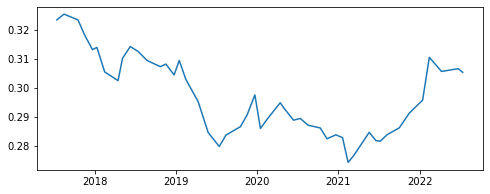

In [25]:
from scipy.signal import argrelextrema
gain2 = remove_noise(gain2, 10)
Zlabeled,Nlabels = ndimage.measurements.label(gain2)

reference = np.percentile(percentiles[:, notree], 90)
reference = np.clip(reference, 0.20, 0.40)
print(f"Reference: {reference}")

struct = ndimage.generate_binary_structure(2, 1)
loss_dilated = binary_dilation(np.copy(loss2), struct, 3)

additional_gain = np.zeros_like(Zlabeled)
deforested_gain = 0
nondeforested_gain = 0
gainpx = []
for idx in range(Nlabels):
    if np.sum(Zlabeled == idx) > 0:
        means = np.mean(percentiles[:, Zlabeled == idx], axis = 1)
        patch = percentiles[:, Zlabeled == idx]
        deforested = np.mean(loss_dilated[Zlabeled == idx] > 0) > 0.10
        ma = moving_average(means, n = 9)
        
        mean_slope = np.mean(dem[Zlabeled == idx])
        counterfactual_events = cfs_flat if mean_slope < 10 else cfs_hill
        if mean_slope >= 20:
            counterfactual_events = cfs_steep
        large_gain = check_for_gain_large(ma, deforested, reference, counterfactual_events,
                                          verbose = False)
        
        if mean_slope < 10:
            gain_events = check_for_gain_subtle(ma)
        else:
            gain_events = []
        
        if len(large_gain) == 0 and len(gain_events) == 0:
            #print("NOGAIN")
            for year in np.unique(gain2[Zlabeled == idx]):
                if np.sum( np.logical_and(Zlabeled == idx, gain2 == year)) > 50:
                    yearlabeled = np.logical_and(Zlabeled == idx, gain2 == year)
                    yearlabeled = remove_noise(yearlabeled, 10)
                    
                    yearlabeled, Nyear = ndimage.measurements.label(yearlabeled)
                    #plt.figure(figsize=(8,8))
                    #sns.heatmap(yearlabeled)
                    for i in range(1, Nyear + 1):
                        means = np.mean(percentiles[:, yearlabeled == i], axis = 1)
                        patch = percentiles[:, yearlabeled == i]
                        deforested = np.mean(loss_dilated[yearlabeled == i] > 0) > 0.10
                        ma = moving_average(means, n = 9)
                        #print("year", i)
                        
                        large_gainyear = check_for_gain_large(ma, deforested, reference, counterfactual_events,False)
                        #print(i, large_gainyear)
                        if np.sum(yearlabeled == i) > 10 and len(large_gainyear) > 0:
                            #print(f"{idx} Addtl Large Gain detected: {len(large_gainyear)} events:"
                  #f" {deforested}, {year}, {np.sum(np.logical_and(Zlabeled == idx, gain2 == year))}"
                  #f" Slope: {mean_slope}, {np.sum(yearlabeled == i)} px")
                            large_gainyear = check_for_gain_large(ma, deforested, 
                                                                  reference,
                                                                  counterfactual_events,
                                                                 verbose = False)
                           
                            #plt.figure(figsize=(8,3))
                            #years = (dates[4:-4] / 365) + 2017
                            #g = sns.lineplot(x = years, y = ma)
                            additional_gain[yearlabeled == i] = year
                        elif len(large_gainyear) == 0 and np.sum(yearlabeled == i) > 1000:
                            print("No addtl gain", np.sum(yearlabeled == i))
                            plt.figure(figsize=(8,3))
                            years = (dates[4:-4] / 365) + 2017
                            g = sns.lineplot(x = years, y = ma)
                        else:
                            continue
        if len(large_gain) == 0 and  len(gain_events) == 0:
            if np.sum(Zlabeled == idx) > 500:
            
                #print("DEFORESTTED", deforested)
                print(f"{idx} No Large Gain detected: {large_gain}: {deforested}, {np.sum(Zlabeled == idx)}")
               # print(f"{idx} Gain detected: {gain_events}")
                means = np.mean(percentiles[:, Zlabeled == idx], axis = 1)
                patch = percentiles[:, Zlabeled == idx]
                deforested = np.mean(loss_dilated[Zlabeled == idx] > 0) > 0.25
                ma = moving_average(means, n = 9)
                #plt.figure(figsize=(8,3))
                #years = (dates / 365) + 2017
                #g = sns.lineplot(x = years, y = means)
                #g.set(ylim = (0, 1))# < 0.05)
                continue
        else:
            #print(f"{idx} Gain detected: {large_gain}")
           # if deforested:
            n_gain_events = len(large_gain)
            print(idx, n_gain_events)
            n_px = np.sum(Zlabeled == idx)
            print(f"{idx} Large Gain detected: {len(large_gain)} events:"
                  f" {deforested}, {year}, {np.sum(np.logical_and(Zlabeled == idx, gain2 == year))}"
                  f" Slope: {mean_slope}, {np.sum(Zlabeled == idx)} px")
            #plt.figure(figsize=(8,3))
            #ma = moving_average(means, n = 7)
            #years = (dates[3:-3] / 365) + 2017
            #g = sns.lineplot(x = years, y = ma)
            
            if deforested and idx > 0:
                
                deforested_gain += np.sum(Zlabeled == idx)
            else:
                nondeforested_gain += np.sum(Zlabeled == idx)
            if n_px < 25:
                if n_gain_events > 6:
                    print(idx)
                    gainpx.append(idx)
            elif n_gain_events > 0:
                print(idx)
                gainpx.append(idx)
            #else:
             #   print("NO GAIN")
                
print("Non deforested:", nondeforested_gain)
print("deforested:", deforested_gain)

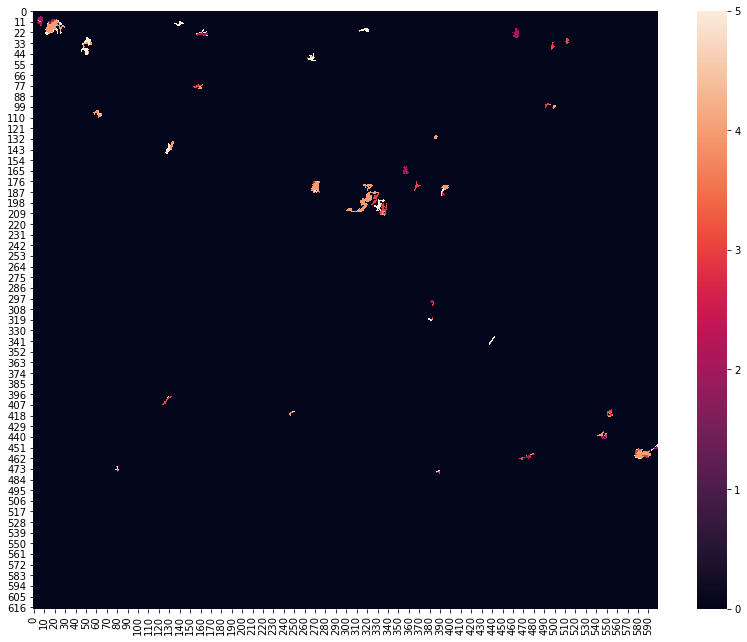

In [26]:
plt.figure(figsize=(14,11))
sns.heatmap((gain2  * np.isin(Zlabeled, gainpx)) +
            additional_gain)

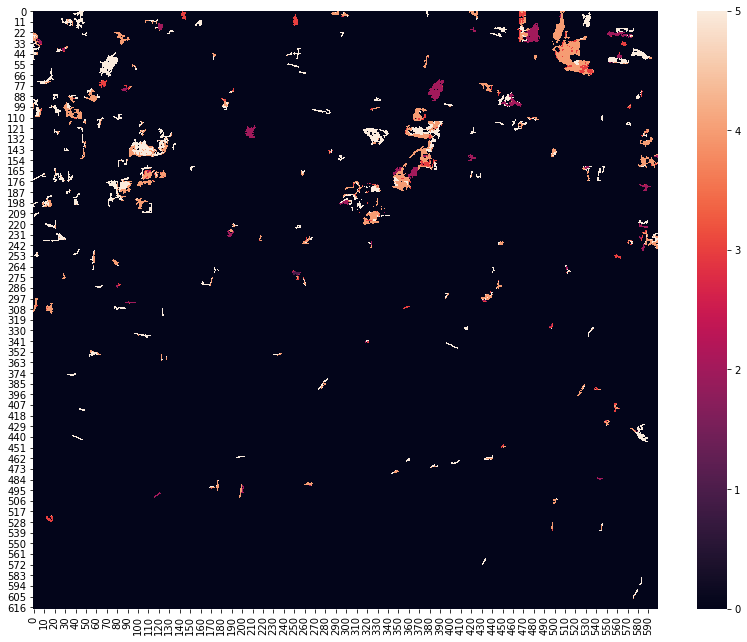

In [27]:
plt.figure(figsize=(14,11))
sns.heatmap((gain2  * ~np.isin(Zlabeled, gainpx)) - additional_gain)

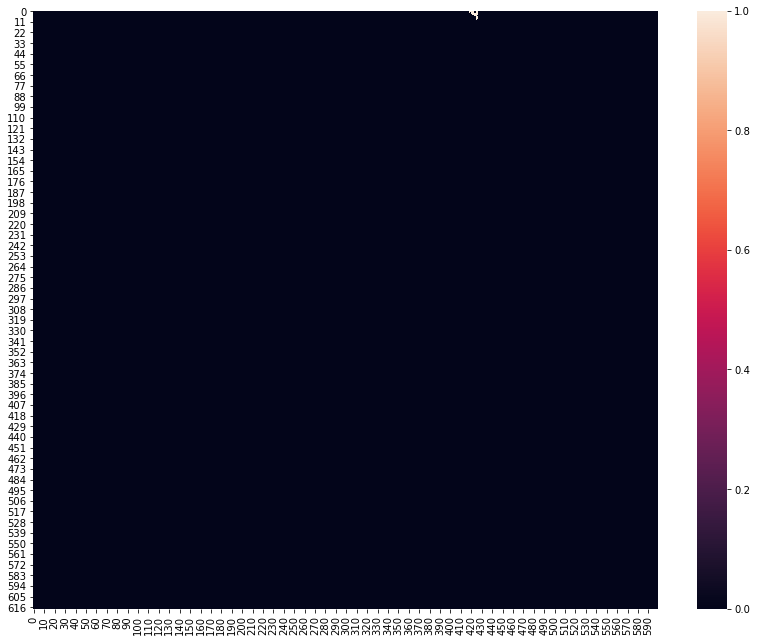

In [28]:
plt.figure(figsize=(14,11))
sns.heatmap(np.logical_and(Zlabeled > 2, Zlabeled < 4))

In [29]:
def check_for_gain_bootstrap(ma_upper, ma_lower, deforested, reference, counterfactual):
    
    #minimum5win = min_filter1d(ma_lower, 3)
    gain_events = []

    for i in range(ma_upper.shape[0]):
        if i < (ma_upper.shape[0] - 6) and (i >= 2):

            if deforested or (i < 6):
                n_lookback = 2 if (i - 2) > 0 else i
            else:
                n_lookback = i
            
            current_baseline = np.median(ma_upper[i-n_lookback:i])

            baseline = current_baseline
            if (baseline < 0.6) or deforested:
            
                baseline = round_down(baseline, 0.05)
                baseline = np.clip(baseline, 0.0, 0.60)
                reference = counterfactual[int(baseline // 0.05)]

                change = (reference - baseline)
                # Do at least 3 image dates in the future reach the tree reference threshold? 
                endline = ma_lower[i+1:ma_upper.shape[0]]
                lastdate_gain = False
                if np.argmax(endline - baseline) >= (endline.shape[0] - 2):
                    if baseline < 0.25:
                        endline = np.array(ma[-1])
                        #reference -= ((noise_factor) / 2)
                        change = (reference - baseline)
                        lastdate_gain = True
                #print(f"{i}, Base/end: {np.around(baseline, 3), np.max(endline)},"
                #      f" change/ref: {np.around(change, 3), reference}")
                # Identify whether change threshold is met, and reference is reached
                

                #print(f"{i}, Base/end: {np.around(baseline, 3), np.max(endline)},"
                #      f" change/ref: {np.around(change, 3), reference}")
                # Identify whether change threshold is met, and reference is reached
                if (np.max(endline) - baseline) > change and (np.max(endline) > reference):
                    #print("WTF")
                    if lastdate_gain:
                        gain_events.append(i)

                    try:
                        gain_date = np.argwhere(np.logical_and(np.array(endline >= reference),
                                                           np.array((endline - baseline) > change)
                                                          )).flatten()[0] + i

                        imgs_after_gain = ma[gain_date:gain_date + 8]

                        if gain_date < (ma.shape[0] - 4):
                            gain_date_after = np.argwhere(imgs_after_gain > np.percentile(
                                            imgs_after_gain, 75)).flatten()[0] + gain_date
                        else:
                            gain_date_after = gain_date
                        gain_value = ma[gain_date]
                        gain_value_max = np.max(ma[gain_date:gain_date + 10])
                        reference_min = calc_threshold_for_notree(gain_value, cfs_trees) + 0.10
                        min_next_6 = (np.min(ma[gain_date_after:gain_date + 8]))
                        no_loss_after_gain = min_next_6 > (reference_min)
                        reference_min = calc_threshold_for_notree(np.max(ma[gain_date:]), cfs_trees)
                        no_loss_after_gain_long = (np.sum(ma[gain_date_after:] < (reference_min + 0.05)) == 0)
                        no_loss_after_gain = np.logical_and(no_loss_after_gain, no_loss_after_gain_long)
                        no_loss_after_gain = np.logical_or(deforested, no_loss_after_gain)
                        if (gain_date - 5) > i:
                            no_decrease_until_gain = np.min(np.array(ma[i+5:gain_date])) >= ma[i]
                        else:
                            no_decrease_until_gain = True
                        #print(i, gain_value, ma[i], no_loss_after_gain, no_decrease_until_gain)
                        if no_loss_after_gain and no_decrease_until_gain:
                            gain_events.append(i)
                    except:
                        continue
                    gain_events.append(i)
    return gain_events

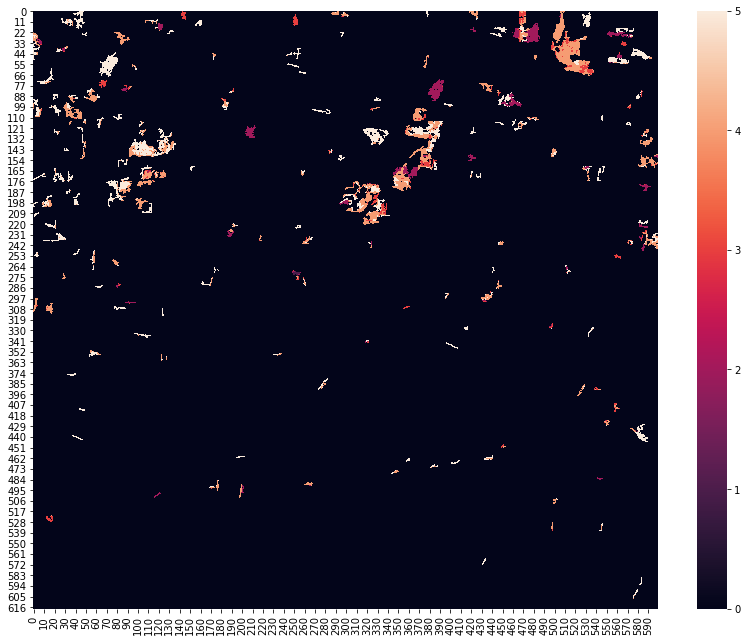

In [30]:
plt.figure(figsize=(14,11))
sns.heatmap((gain2  * ~np.isin(Zlabeled, gainpx)))
#sns.heatmap(Zlabeled == 18)#* ~np.isin(Zlabeled, gainpx))

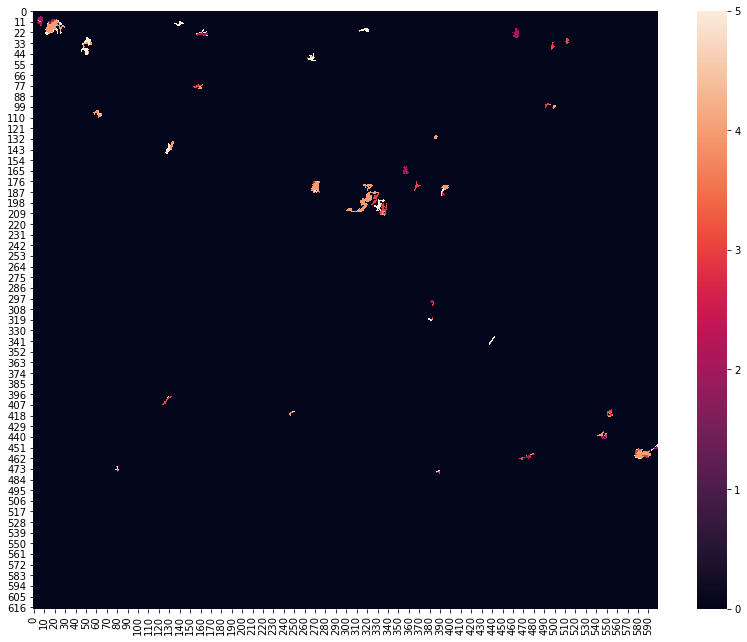

In [31]:
gain2[~np.isin(Zlabeled, gainpx)] = 0.
gain2 = np.maximum(gain2, additional_gain)
plt.figure(figsize=(14,11))
rotational = np.logical_and(gain2 > 0, loss2 > 0)
med = np.median(fs, axis = 0)
med[gain2 > 0] = (gain2[gain2 > 0] + 100)
med[loss2 > 0] = (loss2[loss2 > 0] + 200)
med[np.logical_and(rotational, gain2 > loss2)] = 150.
med[np.logical_and(rotational, loss2 > gain2)] = 160.
sns.heatmap(gain2)

In [32]:
#bbx = [-1.3333777777777778, 7.111122222222222, -1.2778222222222224, 7.166677777777777] #Ghana
#bbx = [-39.88887777777778, -17.666677777777778, -39.83332222222222, -17.61112222222222] # Brazil
#bbx = [102.60442222222223, 14.50002222222222, 102.65997777777777, 14.555577777777778] # thailandd
#bbx = [33.94442222222222, -10.888877777777779, 33.99997777777778, -10.833322222222222] # malawi
#bbx = [83.10272222222223, 19.11112222222222, 83.15827777777777, 19.166677777777778] #inddia
#bbx = [-5.888877777777778, 6.444422222222222, -5.833322222222223, 6.499977777777778] # IVORY
#bbx = [14.388922222222222, 4.500022222222222, 14.444477777777779, 4.555577777777778] # cameroon
#bbx = [7.111122222222222, 5.111122222222222, 7.166677777777777, 5.166677777777777] # Nigeria
#bbx = [105.43802222222223, 19.833322222222222, 105.49357777777777, 19.88887777777778] # Vietnam#
#bbx = [35.88892222222222, -7.999977777777778, 35.94447777777778, -7.944422222222222] # Tanzania
#bbx = [83.21392222222222, 19.166622222222223, 83.26947777777777, 19.22217777777778] # 5578, 1242
#bbx = [95.65942222222223, 17.72222222222222, 95.71497777777778, 17.77777777777778] # myanmar
#bbx = [-98.55557777777777, 21.333322222222222, -98.50002222222223, 21.38887777777778] # mexico
#bbx = [30.555522222222223, -18.055577777777778, 30.61107777777778, -18.00002222222222] # zimbabwe
#bbx = [-5.444477777777777, 12.166622222222221, -5.388922222222222, 12.222177777777778] # mali
def write_tif(arr: np.ndarray,
              point: list,
              x: int,
              y: int,
              out_folder: str,
              suffix="_FINAL") -> str:
    #! TODO: Documentation

    file = out_folder + f"{str(x)}X{str(y)}Y{suffix}.tif"

    west, east = point[0], point[2]
    north, south = point[3], point[1]
    arr[np.isnan(arr)] = 255
    arr = arr.astype(np.int16)

    transform = rs.transform.from_bounds(west=west,
                                               south=south,
                                               east=east,
                                               north=north,
                                               width=arr.shape[1],
                                               height=arr.shape[0])

    print("Writing", file)
    new_dataset = rs.open(file,
                                'w',
                                driver='GTiff',
                                height=arr.shape[0],
                                width=arr.shape[1],
                                count=1,
                                dtype="uint8",
                                compress='zstd',
                                predictor=2,
                                crs='+proj=longlat +datum=WGS84 +no_defs',
                                transform=transform)
    new_dataset.write(arr, 1)
    new_dataset.close()
    return file

write_tif(med, bbx, x, y, 'change/', suffix = 'CHANGENEW_bigall4-2')

Writing change/376X1206YCHANGENEW_bigall4-2.tif


'change/376X1206YCHANGENEW_bigall4-2.tif'

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


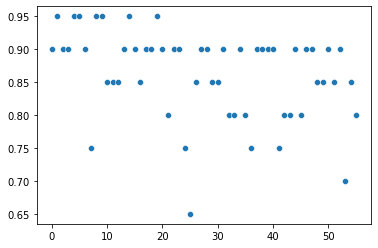

In [33]:
sns.scatterplot([x for x in range(percentiles.shape[0])],
                np.percentile(percentiles[:, notree], 95, axis = (1)))

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

[Text(3.200000000000003, 0.5, 'Anomaly probility')]

<Figure size 1080x576 with 0 Axes>

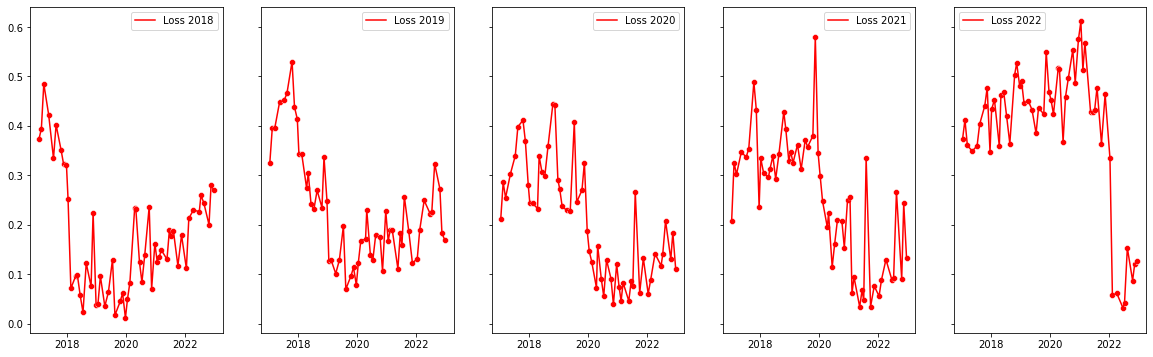

In [34]:
mean_loss18 = np.mean(percentiles[:, loss2 == 1], axis = (1))
mean_loss19 = np.mean(percentiles[:, loss2 == 2], axis = (1))
mean_loss20 = np.mean(percentiles[:, loss2 == 3], axis = (1))
mean_loss21 = np.mean(percentiles[:, loss2 == 4], axis = (1))
mean_loss22 = np.mean(percentiles[:, loss2 == 5], axis = (1))
#mean_nochange_tree = np.mean(percentiles[:, np.logical_and(changemap <= 100, changemap > 40)], axis = (1))


plt.figure(figsize=(15,8))
fig, axs = plt.subplots(ncols=5, figsize = (20, 6), sharey = True)
sns.scatterplot((dates / 365) + 2017, mean_loss18, color = 'red', ax = axs[0])
sns.lineplot((dates / 365) + 2017, mean_loss18, color = 'red', label = 'Loss 2018', ax = axs[0])
sns.scatterplot((dates / 365) + 2017, mean_loss19, color = 'red', ax = axs[1])
sns.lineplot((dates / 365) + 2017, mean_loss19, color = 'red', label = 'Loss 2019', ax = axs[1])
sns.scatterplot((dates / 365) + 2017, mean_loss20, color = 'red', ax = axs[2])
sns.lineplot((dates / 365) + 2017, mean_loss20, color = 'red', label = 'Loss 2020', ax = axs[2])
sns.scatterplot((dates / 365) + 2017, mean_loss21, color = 'red', ax = axs[3])
sns.lineplot((dates / 365) + 2017, mean_loss21, color = 'red', label = 'Loss 2021', ax = axs[3])
sns.scatterplot((dates / 365) + 2017, mean_loss22, color = 'red', ax = axs[4])
sns.lineplot((dates / 365) + 2017, mean_loss22, color = 'red', label = 'Loss 2022', ax = axs[4])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[0])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[1])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[2])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[3])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[4])

#g.set(ylim=(0, 1))
g.set(ylabel = 'Anomaly probility')

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments 

[Text(3.200000000000003, 0.5, 'Anomaly probility')]

<Figure size 1080x576 with 0 Axes>

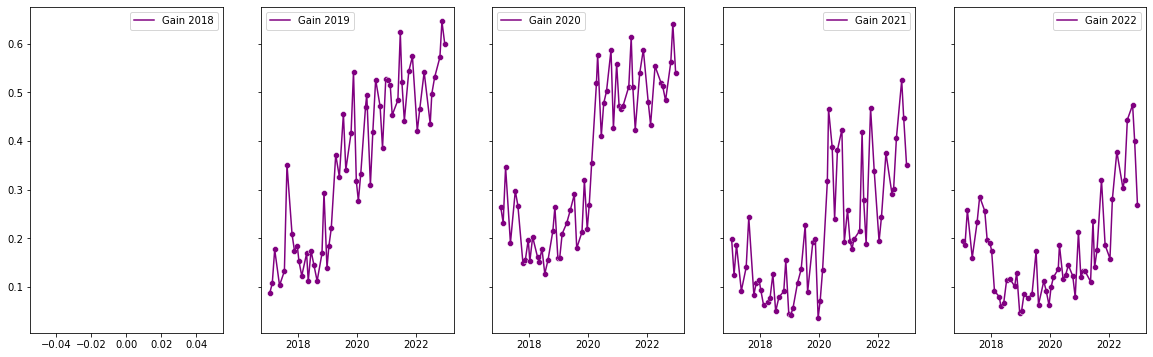

In [35]:
mean_loss18 = np.mean(percentiles[:, gain2 == 1], axis = (1))
mean_loss19 = np.mean(percentiles[:, gain2 == 2], axis = (1))
mean_loss20 = np.mean(percentiles[:, gain2 == 3], axis = (1))
#mean_loss20 = percentiles[:, gain2 == 3][:, 25]
mean_loss21 = np.mean(percentiles[:, gain2 == 4], axis = (1))
mean_loss22 = np.mean(percentiles[:, gain2 == 5], axis = (1))
#mean_nochange_tree = np.mean(percentiles[:, np.logical_and(changemap <= 100, changemap > 40)], axis = (1))


plt.figure(figsize=(15,8))
fig, axs = plt.subplots(ncols=5, figsize = (20, 6), sharey = True)
#sns.scatterplot((dates / 365) + 2017, 1 - mean_loss, color = 'red')
#sns.lineplot((dates / 365) + 2017, 1 - mean_loss, color = 'red', label = 'Loss')
sns.scatterplot((dates / 365) + 2017, mean_loss18, color = 'purple', ax = axs[0])
sns.lineplot((dates / 365) + 2017, mean_loss18, color = 'purple', label = 'Gain 2018', ax = axs[0])
sns.scatterplot((dates / 365) + 2017, mean_loss19, color = 'purple', ax = axs[1])
sns.lineplot((dates / 365) + 2017, mean_loss19, color = 'purple', label = 'Gain 2019', ax = axs[1])
sns.scatterplot((dates / 365) + 2017, mean_loss20, color = 'purple', ax = axs[2])
sns.lineplot((dates / 365) + 2017, mean_loss20, color = 'purple', label = 'Gain 2020', ax = axs[2])
sns.scatterplot((dates / 365) + 2017, mean_loss21, color = 'purple', ax = axs[3])
sns.lineplot((dates / 365) + 2017, mean_loss21, color = 'purple', label = 'Gain 2021', ax = axs[3])
sns.scatterplot((dates / 365) + 2017, mean_loss22, color = 'purple', ax = axs[4])
sns.lineplot((dates / 365) + 2017, mean_loss22, color = 'purple', label = 'Gain 2022', ax = axs[4])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[0])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[1])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[2])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[3])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[4])

#g.set(ylim=(0, 1))
g.set(ylabel = 'Anomaly probility')

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments 

[Text(3.200000000000003, 0.5, 'Anomaly probility')]

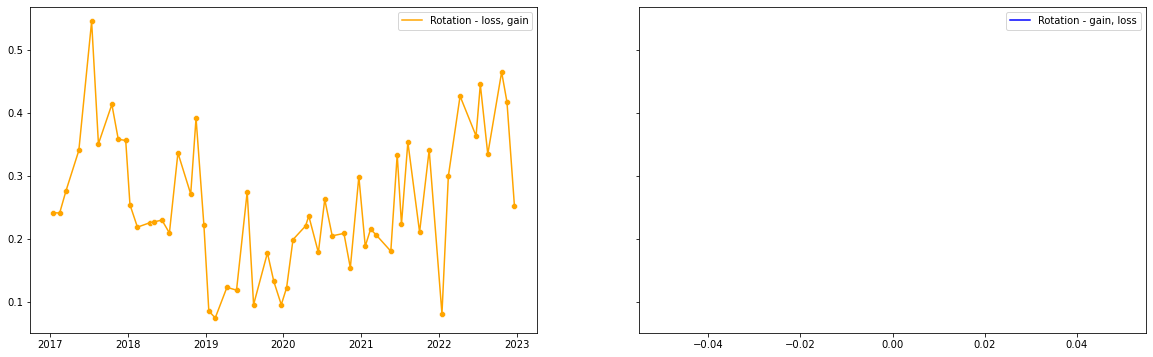

In [36]:
mean_rot = np.mean(percentiles[:, med == 150], axis = (1))
mean_rot2 = np.mean(percentiles[:, med == 160], axis = (1))
#mean_nochange_tree = np.mean(percentiles[:, np.logical_and(changemap <= 100, changemap > 40)], axis = (1))

fig, axs = plt.subplots(ncols=2, figsize = (20, 6), sharey = True)
#sns.scatterplot((dates / 365) + 2017, 1 - mean_loss, color = 'red')
#sns.lineplot((dates / 365) + 2017, 1 - mean_loss, color = 'red', label = 'Loss')
sns.scatterplot((dates / 365) + 2017, mean_rot, color = 'orange', ax = axs[0])
sns.lineplot((dates / 365) + 2017, mean_rot, color = 'orange', label = 'Rotation - loss, gain', ax = axs[0])
sns.scatterplot((dates / 365) + 2017, mean_rot2, color = 'blue', ax = axs[1])
sns.lineplot((dates / 365) + 2017, mean_rot2, color = 'blue', label = 'Rotation - gain, loss', ax = axs[1])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[0])
#g = sns.lineplot((dates / 365) + 2017, mean_nochange_tree, color = 'green', label = 'Stable', ax = axs[1])

#g.set(ylim=(0, 1))
g.set(ylabel = 'Anomaly probility')

#### 